# Particle Filter

In [1]:
%matplotlib inline

## Resampler

In [2]:
def systematic(W, gamma):
    return True

In [3]:
def ESS(W, gamma):
    ESS = 1. / sum([w**2 for w in W])
    if ESS < gamma*len(W):
        return True
    else:
        return False

## Bootstrap Filter

In [4]:
import numpy as np
from scipy.stats import norm, poisson, truncnorm
from numpy.random import multinomial
from math import sqrt, exp, log, pi
import matplotlib.pyplot as plt
import time

In [5]:
def PF(theta, N, yt, resampler=systematic, gamma=0.4, Verbose=False):
    # define parameters from theta
    beta = theta[0:2]
    rho = theta[2]
    delta = theta[3]
    T = len(yt)
    dt = 1.
    
    # t=0
    X = np.array(norm.rvs(size=N, loc = (beta[0] + float(beta[1])/T),
                          scale = (sqrt(delta) / sqrt(1-rho**2))))
    logw = poisson.logpmf(yt[0], mu = dt * np.exp(X))
    m = np.max(logw)
    W = np.exp(logw-m)
    logL = log(1./N * sum(W)) + m
    W = W/sum(W)
    if Verbose==True:
        print "Initialization", "\tLikelihood estimator: ", logL
    
    # t>0
    for t in range(2, T+1):
        if t%200 == 0 & Verbose==True:
            print "Iteration: ", t, "\tLikelihood estimator: ", logL
        X_new = np.empty(N)
        if resampler(W, gamma) == True:
            for n in range(N):
                An = np.where(multinomial(1, W))[0][0]
                mu = rho*X[An] + (1-rho)*beta[0] + (t*(1-rho) + rho)/T*beta[1]
                X_new[n] = norm.rvs(loc=mu, scale=sqrt(delta))
        else:
            for n in range(N):
                An = n
                mu = rho*X[An] + (1-rho)*beta[0] + (t*(1-rho) + rho)/T*beta[1]
                X_new[n] = norm.rvs(loc=mu, scale=sqrt(delta))
        X = X_new
        logw = poisson.logpmf(yt[t-1], mu = dt * np.exp(X))
        m = max(logw)
        W = np.exp(logw-m)
        logL = logL + log(sum(W)) + m - log(N)
        W = W/sum(W)
    return logL

# Simulate data

In [6]:
def simdata_aug(theta, T):
    # define parameters from theta
    beta = theta[0:2]
    rho = theta[2]
    delta = theta[3]
    dt = 1.
    
    # initialization
    yt = np.empty(T)
    eta = norm.rvs(loc = (beta[0] + float(beta[1])/T), scale = (sqrt(delta) / sqrt(1-rho**2)))
    yt[0] = poisson.rvs(dt * exp(eta))
    
    # t>0
    for t in range(2, T+1):
        mu = rho*eta + (1-rho)*beta[0] + (t*(1-rho) + rho)/T*beta[1]
        eta = norm.rvs(loc = mu, scale = sqrt(delta))
        yt[t-1] = poisson.rvs(dt * exp(eta))
    return yt

In [7]:
theta_0 = [1, 0, 0.2, 1]
data_0 = simdata_aug(theta_0, 100)
theta_1 = [1.5, 3, 0.6, 1.5]
data_1 = simdata_aug(theta_1, 100)

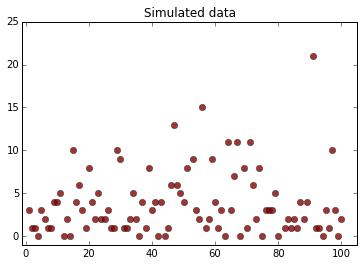

In [8]:
plt.plot(range(1,101), data_0,  'o', c='darkred', alpha=0.8)
plt.ylim([-1,25])
plt.xlim([-1,105])
plt.title('Simulated data')

## Test PF

### Sampling schemes

In [9]:
Ls_sys = np.empty(500)
Ls_ESS = np.empty(500)
times = np.empty(shape=(500, 2))
for i in range(500):
    start = time.time()
    Ls_sys[i] = PF(theta_0, 100, data_0)
    end = time.time()
    times[i, 0] = end-start
    
    start = time.time()
    Ls_ESS[i] = PF(theta_0, 100, data_0, resampler=ESS)
    end = time.time()
    times[i, 1] = end-start
    
    if i%100==0:
        print i
print np.mean(Ls_sys), np.std(Ls_sys)
print np.mean(Ls_ESS), np.std(Ls_ESS)
print np.mean(times, axis=0)

0
100
200
300
400
-264.366298565 4.94814065282
-263.045679032 3.92571292512
[ 0.24996315  0.18878245]


### Number of particles

In [10]:
Ls_1k = np.empty(50)
times_1k = np.empty(50)
for i in range(50):
    if i%5==0:
        print i
    start = time.time()
    Ls_1k[i] = PF(theta_0, 1000, data_0)
    end = time.time()
    times_1k[i] = end-start
print np.mean(Ls_1k), np.std(Ls_1k)
print np.mean(times_1k)

0
5
10
15
20
25
30
35
40
45
-260.269817255 0.714430193034
7.33796948433


### Other parameters

In [16]:
theta_2 = [0,0,0,0]

In [12]:
Ls_1 = np.empty(500)
Ls_2 = np.empty(500)
times = np.empty(shape=(500, 2))
for i in range(500):
    start = time.time()
    Ls_1[i] = PF(theta_1, 100, data_0, resampler=ESS)
    end = time.time()
    times[i, 0] = end-start
    
    start = time.time()
    Ls_2[i] = PF(theta_2, 100, data_0, resampler=ESS)
    end = time.time()
    times[i, 1] = end-start
    
    if i%50==0:
        print i

0
50
100
150
200
250
300
350
400
450


In [15]:
print np.mean(Ls_1), np.std(Ls_1)
print np.mean(Ls_2), np.std(Ls_2)
print np.mean(times, axis=0)

-301.836653808 2.10812340986
-760.593698079 1.13686837722e-13
[ 0.21910377  0.16407303]


# PMCMC

In [29]:
class h_norms():
    def __init__(self):
        pass
    
    def logpdf(self, theta, param, scale=1.):
        logpdfs = np.empty(4)
        logpdfs[0:2] = norm.logpdf(theta[0:2], loc=param[0:2], scale=scale)
        
        leftcut = (-1-param[2])/scale
        rightcut = (1-param[2])/scale
        logpdfs[2] = truncnorm.logpdf(theta[2], leftcut, rightcut, loc=param[2], scale=scale)
        
        myclip_a, myclip_b = 0, float("inf")
        my_mean = param[3]
        my_std = scale
        a, b = (myclip_a - my_mean) / my_std, (myclip_b - my_mean) / my_std
        logpdfs[3] = truncnorm.logpdf(theta[3], a, b, loc=my_mean, scale=my_std)
        
        return logpdfs

    def rvs(self, param, scale=1.):
        new_theta = np.empty(4)
        new_theta[0:2] = norm.rvs(size=2, loc=param[0:2], scale=scale)
        
        leftcut = (-1-param[2])/scale
        rightcut = (1-param[2])/scale

        new_theta[2] = truncnorm.rvs(leftcut, rightcut, loc=param[2], scale=scale)
        
        myclip_a,myclip_b = 0,float("inf")
        my_mean = param[3]
        my_std = scale
        a, b = (myclip_a - my_mean) / my_std, (myclip_b - my_mean) / my_std
        new_theta[3] = truncnorm.rvs(a, b,loc=my_mean, scale=my_std)
        return new_theta

In [26]:
def pmcmc(n_iter, data, theta0, prop=h_norms(), pf=PF, n_particles=100, Verbose=False):
    L = lambda theta: pf(theta, n_particles, data)
    h = lambda theta, mean: np.sum(prop.logpdf(theta, mean))
    #p = lambda theta: np.prod(prior.pdf(theta))
    theta_i = theta0
    results = np.empty((n_iter, 4))
    
    for i in range(n_iter):
        if i%50==0 & Verbose==True:
            print "Iteration ", i, theta_i
        theta_star = prop.rvs(theta_i)
        logr = L(theta_star) + h(theta_i, theta_star) - (
            L(theta_i) + h(theta_star, theta_i))
        if logr > 0:
            results[i,:] = theta_star
            theta_i = theta_star
        else:
            u = np.random.uniform(0,1)
            if u < exp(logr):
                results[i,:] = theta_star
                theta_i = theta_star
            else:
                results[i,:] = theta_i
    return(results)

# Running the algorithm and plotting the results

In [30]:
import pylab

In [32]:
data = np.load('Samples/ESS/data1_5000badstart_1_1_ESS.npy')

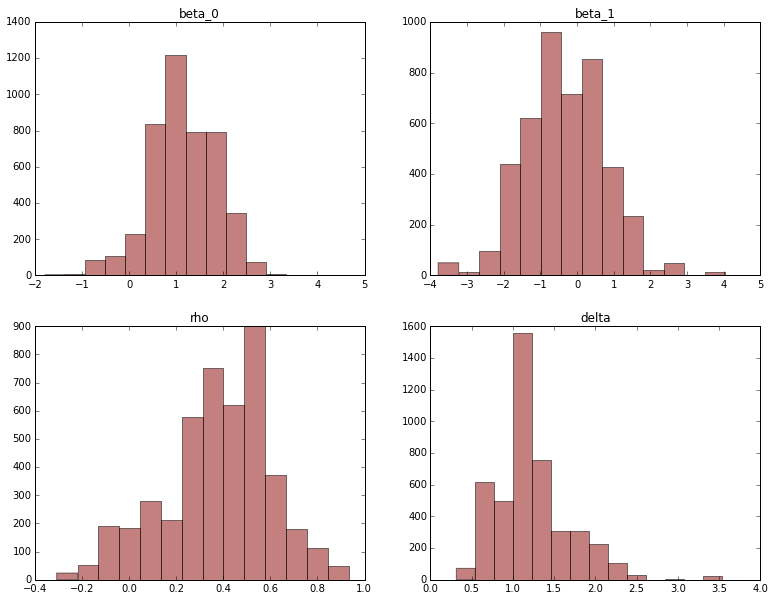

In [33]:
pylab.rcParams['figure.figsize'] = (13.0, 10.0)
titles = ['beta_0', 'beta_1', 'rho', 'delta']
for i in range(4):
    bins = np.linspace(data[500:,i].min(), data[500:,i].max(), 15)
    plt.subplot(2, 2, 1+i)
    plt.title(titles[i])
    plt.hist(data[500:,i], bins, alpha=0.5, color='darkred')